# Homework 3: Building an NDArray library

In this homework, you will build a simple backing library for the processing that underlies most deep learning systems: the n-dimensional array (a.k.a. the NDArray).  Up until now, you have largely been using numpy for this purpose, but this homework will walk you through developing what amounts to your own (albeit much more limited) variant of numpy, which will support both CPU and GPU backends.  What's more, unlike numpy (and even variants like PyTorch), you won't simply call out to existing highly-optimized variants of matrix multiplication or other manipulation code, but actually write your own versions that are reasonably competitive will the highly optimized code backing these standard libraries (by some measure, i.e., "only 2-3x slower" ... which is a whole lot better than naive code that can easily be 100x slower).  This class will ultimately be integrated into `needle`, but for this assignment you can _only_ focus on the ndarray module, as this will be the only subject of the tests.

**Note**: To avoid exhausting limited GPU resources in Colab, start by using CPU runtime for coding and testing non-GPU functions. Switch to GPU runtime when testing CUDA or GPU-accelerated code. This approach ensures efficient GPU usage and prevents running out of resources during critical tasks.


In [ ]:
# Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
%cd /content/drive/MyDrive/10714/DL-Systems-Project

!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
!pip3 install pybind11

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714
/content/drive/MyDrive/10714/DL-Systems-Project
  Cloning https://github.com/dlsys10714/mugrade.git to /tmp/pip-req-build-l8ij1h00
  Running command git clone --filter=blob:none --quiet https://github.com/dlsys10714/mugrade.git /tmp/pip-req-build-l8ij1h00
  Resolved https://github.com/dlsys10714/mugrade.git to commit ac73f725eb2ce0e2c6a38fa540035ee970b8b873
  Preparing metadata (setup.py) ... done


In [ ]:
!ls

bench_quantization_large.py  build	     proj_andrew.ipynb	src
bench_quantization.py	     CMakeLists.txt  python		tests
bench_quantization_xl.py     Makefile	     README.md


In [ ]:
!make

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- Found pybind11: /usr/local/lib/python3.12/dist-packages/pybind11/include (found version "3.0.1")
-- Found cuda, building cuda backend
Thu Nov 20 21:22:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|

The make command reads the Makefile in the current directory. The Makefile contains rules that define how to build targets (like executables or libraries). For each target specified in the Makefile, make checks the timestamps of the target file and its dependencies (like .c, .cpp, or .h files). If any dependency has been modified recently, it must rebuild the target.

In [ ]:
%set_env PYTHONPATH ./python
%set_env NEEDLE_BACKEND nd

env: PYTHONPATH=./python
env: NEEDLE_BACKEND=nd


In [ ]:
import sys
sys.path.append('./python')

## Int8 quantization checks

These cells validate the new int8 quantization path (post-training).
They run quickly on CPU/GPU in Colab and ensure the quantized linear layer
tracks the float32 reference within a small tolerance.


In [ ]:
!python3 -m pytest -v tests/hw3/test_quantization.py

============================= test session starts ==============================
platform linux -- Python 3.12.12, pytest-8.4.2, pluggy-1.6.0 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/drive/MyDrive/10714/DL-Systems-Project
plugins: typeguard-4.4.4, langsmith-0.4.42, anyio-4.11.0
collected 21 items                                                             

tests/hw3/test_quantization.py::test_quantize_round_trip PASSED          [  4%]
tests/hw3/test_quantization.py::test_per_channel_quantization_shapes PASSED [  9%]
tests/hw3/test_quantization.py::test_linear_quantized_matches_float PASSED [ 14%]
tests/hw3/test_quantization.py::test_quantize_zero_tensor PASSED         [ 19%]
tests/hw3/test_quantization.py::test_quantization_per_axis_negative_axis PASSED [ 23%]
tests/hw3/test_quantization.py::test_quantized_tensor_cache_reuse PASSED [ 28%]
tests/hw3/test_quantization.py::test_quantized_matmul_shape PASSED       [ 33%]
tests/hw3/test_quantization.py::test_linear_dis

## Quantization performance benchmark

Runs a float32 vs int8 (weights) Linear forward benchmark. Adjust flags to explore other shapes.


In [ ]:
!python3 bench_quantization.py --batch 256 --in-features 1024 --out-features 4096 --steps 30

Backend: nd
Using needle backend
float32 avg: 29.119 ms
int8 avg:   28.800 ms
speedup:    1.01x

Full results: {'float32_total_s': 0.8735800450001534, 'int8_total_s': 0.863994803000196, 'float32_avg_ms': 29.119334833338446, 'int8_avg_ms': 28.799826766673203, 'speedup_x': 1.0110940968240467}


## Large-mode quantization benchmark

Heavier feedforward-style run (two Linear layers). Adjust flags for size/steps.


In [ ]:
!python3 bench_quantization_large.py --batch 512 --in-features 4096 --hidden 4096 --out-features 4096 --steps 20

Backend: nd
Using needle backend
float32 avg: 491.531 ms
int8 avg:   416.374 ms
speedup:    1.18x

Full results: {'float32_total_s': 9.830616287000112, 'int8_total_s': 8.327470392000123, 'float32_avg_ms': 491.5308143500056, 'int8_avg_ms': 416.37351960000615, 'speedup_x': 1.1805045018765845}


## Extra-large quantization benchmark

Four-layer stack at large hidden size to stress performance. Adjust flags as needed.


In [ ]:
!python3 bench_quantization_xl.py --batch 1024 --dim 8192 --steps 10

Backend: nd
Using needle backend
float32 avg: 7517.686 ms
int8 avg:   7438.163 ms
speedup:    1.01x

Full results: {'float32_total_s': 75.17685518000008, 'int8_total_s': 74.38163200900021, 'float32_avg_ms': 7517.6855180000075, 'int8_avg_ms': 7438.163200900021, 'speedup_x': 1.010691122922708}


## Quantization memory comparison

Reports parameter counts and memory for float32 vs int8-quantized weights.


In [ ]:
!python3 bench_quantization_memory.py --in-features 1024 --out-features 4096

Using needle backend
Backend: nd
Layer: Linear(1024, 4096)
Parameters: weights=4,194,304, bias=4,096, total=4,198,400
Float32 memory: 16.794 MB
Int8 memory:   4.231 MB (weights int8 + scale/zp + float32 bias)
Memory reduction: 74.80%


## Quantization memory plot

Runs the memory comparison script across multiple layer sizes and saves a plot.


Using needle backend
Backend: nd
Layer: Linear(1024, 4096)
Parameters: weights=4,194,304, bias=4,096, total=4,198,400
Float32 memory: 16.794 MB
Int8 memory:   4.231 MB (weights int8 + scale/zp + float32 bias)
Memory reduction: 74.80%
Saved plot to memory_plot.png


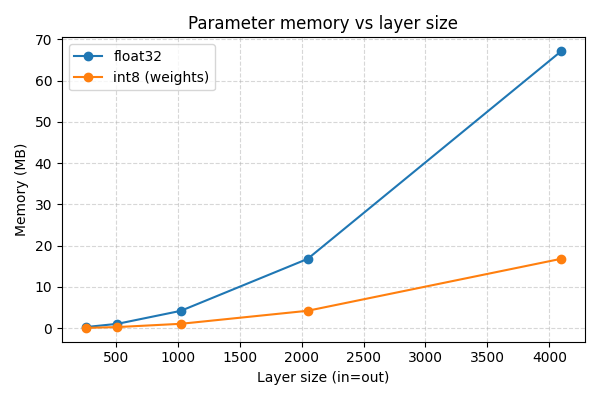

In [64]:
!python3 bench_quantization_memory.py --sizes 256,512,1024,2048,4096 --save memory_plot.png
from IPython.display import Image, display
display(Image('memory_plot.png'))